In [1]:
import pandas as pd
import numpy
import json
import dateparser
import datetime
import seaborn as sns
import matplotlib as mpl
from scipy import stats
sns.set_style('white', {'legend.frameon':True})
mpl.rcParams['figure.figsize'] = 25, 10

SUBOR_PERSONALNYCH = "data/personal_valid.csv"
SUBOR_OSTATNYCH = "data/other_valid.csv"
SUBOR_VYSTUP = "data/predspracovane_medianove_valid.csv"
SUBOR_ULOZENYCH_HODNOT = "data/ulozene.json"
NACITAJ_ULOZENE = True
VYHOD_RIADKY_S_PRAZDNOU_KLASOU = True
VYHOD_AUTLAJEROV = False


Mediany a priemery sa nacitavaju alebo ukladaju do JSONa a vsetky mozne nastavovania sme dali na zaciatok.
Tak hadam to teraz uz je znovupouzitelnejsie.

In [2]:
mediany = {}
priemery = {}


def nacitajUlozeneHodnoty(nazov_suboru):
    with open(nazov_suboru, 'r') as subor:
        hodnoty = json.load(subor)
    return hodnoty["priemery"], hodnoty["mediany"]


if NACITAJ_ULOZENE:
    priemery, mediany = nacitajUlozeneHodnoty(SUBOR_ULOZENYCH_HODNOT)


In [3]:

def vek(vstup):
    try:
        vystup = int(abs(float(vstup)))/1000 if abs(float(vstup)) > 1000 else int(abs(float(vstup)))
        if vystup is not int(vystup):
            vystup *= 10
        if vystup % 100 is 0:
            vystup /= 100
        return vystup
    except ValueError:
        return numpy.nan


def datum(vstup):
    formaty = ['%Y-%m-%d', '%Y/%m/%d', '%y-%m-%d', '%d/%m/%Y']
    vstup = vstup[:10].strip()
    if not len(vstup):
        return numpy.nan
    vystup = dateparser.parse(vstup, formaty)
    if vystup is None:
        raise Exception('Nenaznamy format datumu:' + vstup)
    if vystup.year > 2018:
        vystup = vystup - datetime.timedelta(36500)     
    if vystup.year < 1900:
        vystup = datetime.datetime(1900 + vystup.year % 100, vystup.month, vystup.day)
    return vystup


konvertovace = {
    'age' : vek,
    'date_of_birth': datum
}

personalne = pd.read_csv(SUBOR_PERSONALNYCH, na_values='?', index_col=0, converters=konvertovace, )



Nacitane personalne data, s opravenym vekom a datumom narodenia.

In [4]:
bulo = lambda vstup: numpy.nan if pd.isna(vstup) or len(str(vstup).strip()) is 0 else str(vstup).strip().lower().split('.')[0][0] == 't'
classa = lambda vstup: vstup.lower().split('.|')[0]
trimho = lambda vstup: vstup.strip()


def js(vstup):
    try:
        return str(vstup).replace("'", '"')
    except json.JSONDecodeError:
        pass

konvertovace = {
    "FTI measured": bulo,
    "tumor": bulo,
    "lithium": bulo,
    "thyroid surgery": bulo,
    "I131 treatment": bulo,
    "goitre": bulo,
    "hypopituitary": bulo,
    "query on thyroxine": bulo,
    "T3 measured": bulo,
    "TBG measured": bulo,
    "pregnant": bulo,
    "class": classa,
    "medical_info": js,
    "education": trimho
}
other = pd.read_csv(SUBOR_OSTATNYCH, na_values=['?', '??', ' ?'], index_col=0, true_values=['t'],
                    false_values=['f'],
                    converters=konvertovace)
other = other.drop(columns=['TBG'])


Nacitane ostatne udaje s opravenymi boolovskymi hodnotami a vyhodenym prazdnym stlpcom TBG

In [5]:
def rozober_json(vstup):
    try:
        return pd.Series(json.loads(vstup))
    except json.JSONDecodeError:
        return pd.Series(json.loads('{}'))
other = other.join(other['medical_info'].apply(rozober_json))
other = other.drop(columns='medical_info')

Rozoberanie jsonu v medical_info stlpci na jednotlive stlpce

In [6]:
for stlpec in ['TSH measured', 'query hyperthyroid', 'TT4 measured', 'on antithyroid medication', 'sick', 'T4U measured', 'psych', 'query hypothyroid']:
    other[stlpec] = other[stlpec].apply(bulo)

other = other.replace(to_replace=r'^\?.*$', value=numpy.nan, regex=True)

Oprava pridanych boolovskych stlpcov a nahradenie ? za NaN

In [7]:
vsetko = other.merge(personalne, on=('name', 'address'))
vsetko = vsetko.replace(to_replace=[None], value=numpy.nan)

Spojenie suborov a nahradenie None za NaN

In [8]:
def agreguj(vstup):
    vstup = vstup.reset_index()
    for hodnota in vstup.values:
        if not pd.isna(hodnota[1]) and str(hodnota[1]).strip() != '':
            return hodnota[1]
    return numpy.nan


In [9]:
vsetko = vsetko.groupby(['name', 'address']).aggregate(agreguj).reset_index()

Spojenie rovnakych riadkov. Momentalne berieme prvu neprazdnu hodnotu. V pripade ze by bolo neprazdnych hodnot viac, dal by sa pouzit priemer pre numericke atributy a modus pre kategoricke, pripadne najcastejsia hodnota v celom datasete ak by pocet vyskytov bol rovnaky.

In [10]:
vsetko.FTI = pd.to_numeric(vsetko.FTI)

In [11]:
if VYHOD_RIADKY_S_PRAZDNOU_KLASOU:
    vsetko = vsetko[vsetko['class']!='']


Odstranenie riadkov s prazdnou hodnotou class - tieto riadky by nam pri trenovani nepomohli

In [12]:
nenumericke = vsetko.select_dtypes(exclude=numpy.number).columns
modusy = {}
for stlpec in nenumericke:
    modusy[stlpec] = vsetko[stlpec].mode()
vsetko = vsetko.replace(numpy.nan, value=modusy)


Doplnenie kategorickych atributov najcastejsou hodnotou

In [13]:
numericke = vsetko.select_dtypes(include=numpy.number).columns
if not NACITAJ_ULOZENE:
    for stlpec in numericke:
        mediany[stlpec] = vsetko[stlpec].median()
medianove = vsetko.fillna(mediany)
# print(mediany)
# vsetko.info()

Doplnenie chybajucich hodnot numerickych atributov medianom

In [14]:
priem = []


def priemeraj(s): #s ako nazov stlpca pochopitelne...
    if not NACITAJ_ULOZENE:
        for hodnota in vsetko[s].unique():
            priemery[hodnota] = {}
            for stlpec in numericke:
                priemery[hodnota][stlpec] = vsetko[vsetko[s]==hodnota][stlpec].mean()
        
    for hodnota in vsetko[s].unique():
        priem.append(vsetko[vsetko[s]==hodnota].replace(numpy.nan, value=priemery[hodnota]))
    return pd.concat(priem)


In [15]:
priemerove = priemeraj('occupation')

In [16]:
if not NACITAJ_ULOZENE:
    subor = open(SUBOR_ULOZENYCH_HODNOT, "w")
    udaje = {}
    udaje["mediany"] = mediany
    udaje["priemery"] = priemery
    json.dump(udaje, subor)
    subor.close()



Doplnenie chybajucich numerickych atributov pomocou priemerov segmentov podla stlpca occupation.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f830351b358>,
      dtype=object)

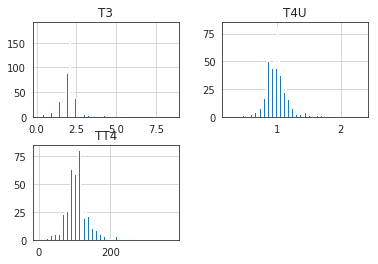

In [17]:
priemerove.hist(bins=100, column=["T4U", "TT4", "T3"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f830350dd30>,
      dtype=object)

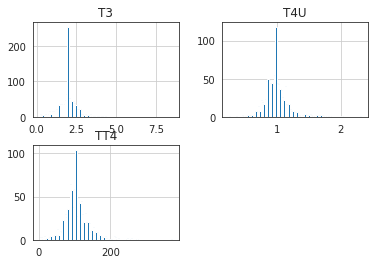

In [18]:
medianove.hist(bins=100, column=["T4U", "TT4", "T3"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8302ff4358>,
      dtype=object)

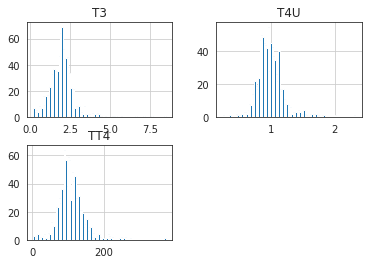

In [19]:
vsetko.hist(bins=100, column=["T4U", "TT4", "T3"])


Z vyssie uvedenych histogramov vyplyva, ze lepsie je pouzit doplnenie chybajucich hodnot pomocou priemerov segmentov.

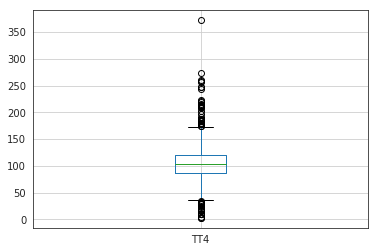

In [20]:
priemerove.boxplot(column=["TT4"])

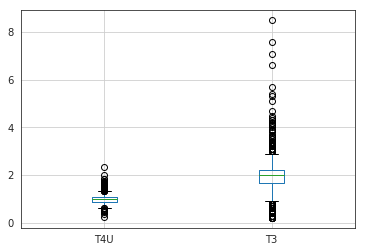

In [21]:
priemerove.boxplot(column=["T4U", "T3"])

In [22]:
vyhodeny_autlajery = medianove
if VYHOD_AUTLAJEROV:
    vyhodeny_autlajery = medianove[(numpy.abs(stats.zscore(medianove.select_dtypes(numpy.number))) < 5).all(axis=1)]


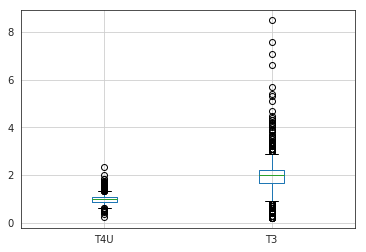

In [23]:
vyhodeny_autlajery.boxplot(column=["T4U", "T3"])

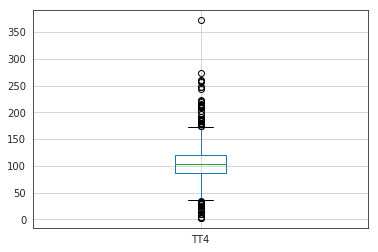

In [24]:
vyhodeny_autlajery.boxplot(column=["TT4"])

In [25]:
len(medianove) - len(vyhodeny_autlajery)

0

Ocividne bolo odstranenych 58 riadkov

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f830293c898>,
      dtype=object)

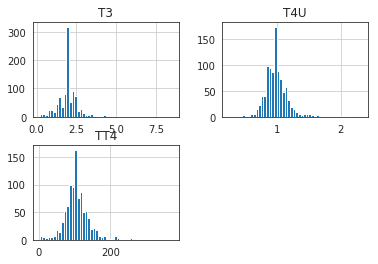

In [26]:
vyhodeny_autlajery.hist(bins=50, column=["T4U", "TT4", "T3"])

In [27]:
dolny_quantiles = priemerove.quantile(0.02)
horny_quantiles = priemerove.quantile(0.98)
nahradeny_autlajery = priemerove.mask(priemerove.select_dtypes(numpy.number) < dolny_quantiles, dolny_quantiles, axis=1)
nahradeny_autlajery = nahradeny_autlajery.mask(nahradeny_autlajery.select_dtypes(numpy.number) > horny_quantiles, horny_quantiles, axis=1)


Vyratanie kvantilov, ktorymi budeme nahradzati

Nahradenie vyhchylenych hodnot kvantilmi.

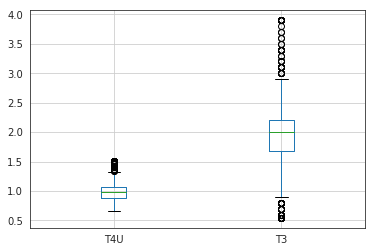

In [28]:
nahradeny_autlajery.boxplot(column=["T4U", "T3"])

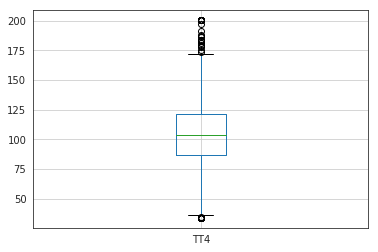

In [29]:
nahradeny_autlajery.boxplot(column=["TT4"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f830250fb00>,
      dtype=object)

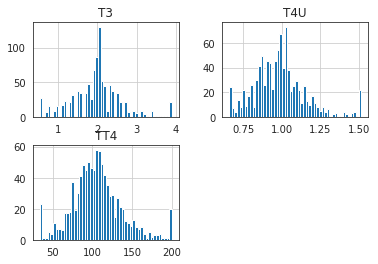

In [30]:
nahradeny_autlajery.hist(bins=50, column=["T4U", "TT4", "T3"])

Zda sa, ze vyhodenie vychylenych hodnot je lepsie, nakolko vysledne rozdelenie je rovnomernejsie.

In [31]:
# barco = vyhodeny_autlajery.select_dtypes(numpy.number)
# barco['class'] = vyhodeny_autlajery['class'] 
# sns.pairplot(barco, 'class')

Rozdelenia hodnot sa predspracovanim zmenili len minimalne. 
Stlpec FTI zda sa, ze koreluje s hodnotou TT4

In [32]:
vyhodeny_autlajery.to_csv(SUBOR_VYSTUP)